# ARIMA Model For Venice

**Reading Data File**

There are two datasets provided
1. **The LAbike dataset** had 639786 unique trip details with 13 attributes pertaining to start and end
station IDs with their co-ordinates, start and end times, pass holder type and trip category
whether one way or round trip.
2. **Stations_Table dataset** provides the details of each 143 stations with their unique Station IDs,
station names and their Go Live Date.

In [6]:
#Importing reuired packages
import pandas as pd
import numpy as np

df=pd.read_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/LABikeData.xlsx')
df2 = pd.read_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/Station_Table.xlsx')

In [2]:
#For some station Start latitude is zeroso removing it
df=df[df['start_lat']!=0]
df.describe()
df.columns
df.start_station.nunique()
df2.Station_ID.nunique()

143

In [11]:
#Merging the two datasets on station id's
df3=df.set_index('start_station').join(df2.set_index('Station_ID'))

**Resampling**

We resampled the data to have number of trips on a particular day for every year

In [12]:
df4 = df3.loc[:,('start_time','Region', 'trip_id')]
df4['start_time'] = pd.to_datetime(df4.start_time, format = '%d/%m/%Y %I:%M:%S %p' )
df4
df4['Day'] = df4.start_time.dt.dayofweek
df4['Date'] = df4.start_time.dt.day
df4['Month'] = df4.start_time.dt.month
df4['Hour'] = df4.start_time.dt.hour
df4['Year'] = df4.start_time.dt.year
df4.groupby(['Date','Month','Year'])['trip_id'].count()

Date  Month  Year
1     1      2017     273
             2018     781
      2      2017     419
             2018     777
      3      2017     397
             2018     722
      4      2017     419
             2018     643
      5      2017     486
             2018     712
      6      2017     679
             2018     923
      7      2017     532
             2018     723
      8      2016     633
             2017     838
             2018    1180
      9      2016     775
             2017     643
             2018    1202
      10     2016     592
             2017     821
             2018    1059
      11     2016     558
             2017     804
             2018    1035
      12     2016     476
             2017     746
             2018     622
2     1      2017     262
                     ... 
30    9      2016     700
             2017     862
             2018    2494
      10     2016     328
             2017     719
             2018     888
      11     2016   

Converting our data in time series format which will then be used to fit ARIMA model

In [13]:
Data_Venice= df4.loc[df4['Region']=='Venice',:]
Data_Venice.index = Data_Venice.start_time
Data_Venice_D = Data_Venice.resample('D').count()
Data_Venice_D = Data_Venice_D.rename(columns={'Region':'trips'})
Data_Venice_D=Data_Venice_D.drop(Data_Venice_D.columns[[0,2,3,4,5,6,7]],axis=1)
Data_Venice_D

,trips
start_time,
2017-09-01,5
2017-09-02,0
2017-09-03,0
2017-09-04,0
2017-09-05,0
2017-09-06,0
2017-09-07,100
2017-09-08,175
2017-09-09,213


**Data Partition**

Now let us have have a visual representation of our data by dividing it into training and test data

Text(0.5, 1.0, 'Venice trips per day')

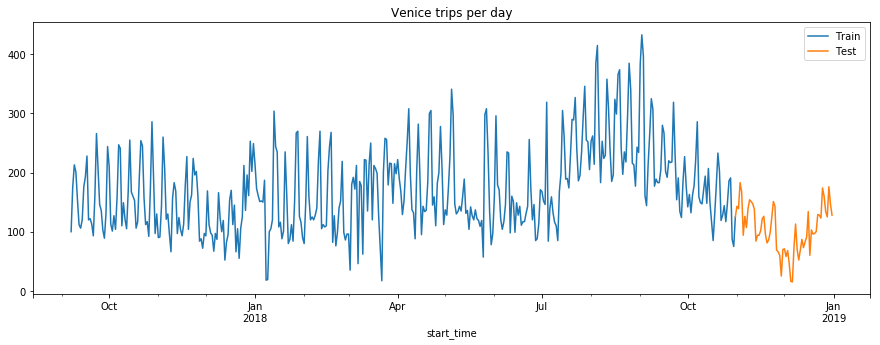

In [14]:
import matplotlib.pyplot as plt
train_ven = Data_Venice_D.loc['2017-09-07':'2018-10-31']
test_ven = Data_Venice_D.loc['2018-10-31':]
train_ven.shape,test_ven.shape
train_ven.trips.plot(label = 'Train')
test_ven.trips.plot(label="Test", figsize = (15,5))
plt.legend()
plt.title('Venice trips per day')

An ARIMA model is characterized by 3 terms: p, d, q
where,
p is the order of the AR term
q is the order of the MA term
d is the number of differencing required to make the time series stationary
If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.
P, D & Q represents the same parameters ut for seasonal component.

Here we have used grid search method to iterate for various values of the parameters and checked the AIC value for each combination of parameters. The one which give lowest AIC value is the optimal combination of parameter which we used in fitting our model

In [15]:
import itertools
#Defining parameters p, d, q to take value from 0 to 2
p = d = q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq=list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

In [ ]:
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore") # specify to ignore warning messages
arr=[]
min_aic = 1e64
for param in pdq:
 for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(train_ven,
                                            order=param,
                                            seasonal_order=param_seasonal, enforce_invertibility=False,
                                            enforce_stationarity=False
                                            )

            results = mod.fit()
            arr.append(results.aic)
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < min_aic:
                min_aic = results.aic
                best_param,best_param_seasonal = param, param_seasonal

The best model is obtained by choosing ARIMA(1,0,1)(1,2,2)28.

**Model Fitting**

In [16]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(train_ven,
                                order=(0,1,2),
                                seasonal_order=(1, 2, 2, 28),
                                enforce_invertibility=False,
                               enforce_stationarity=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5985      0.054    -11.050      0.000      -0.705      -0.492
ma.L2         -0.2270      0.056     -4.044      0.000      -0.337      -0.117
ar.S.L28      -0.0016      0.097     -0.016      0.987      -0.192       0.189
ma.S.L28      -1.9488      0.093    -20.930      0.000      -2.131      -1.766
ma.S.L56       1.0000      0.162      6.162      0.000       0.682       1.318
sigma2      2429.8180      0.000   2.39e+07      0.000    2429.818    2429.818


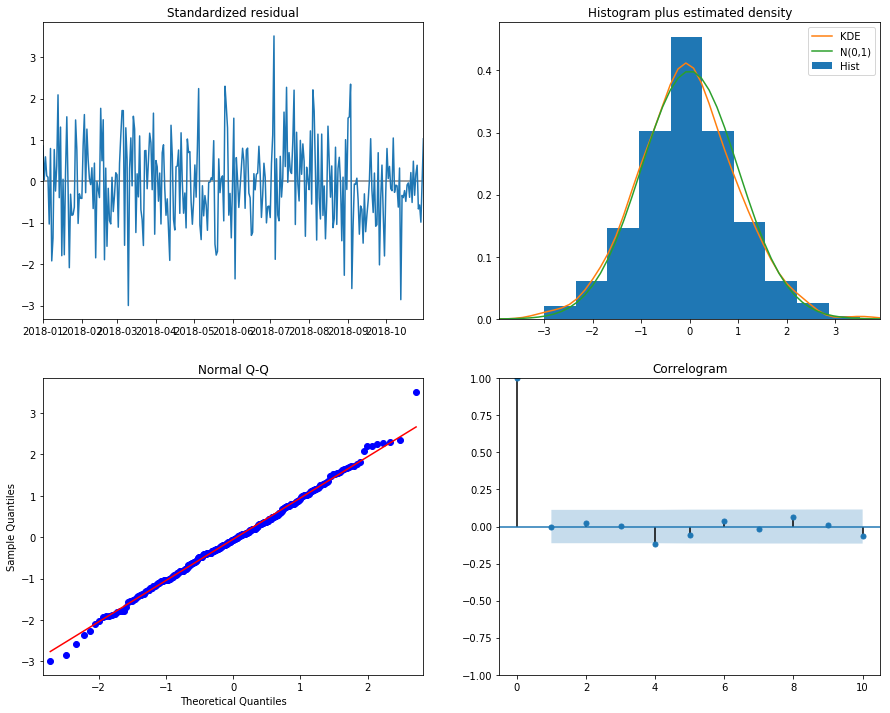

In [17]:
# Residual Diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**Validation**

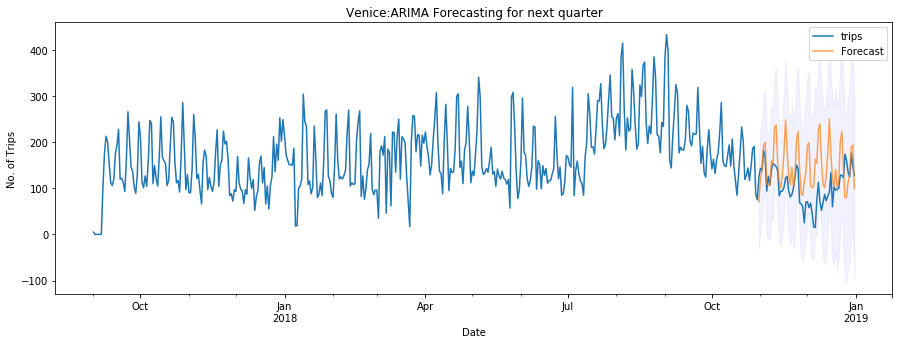

In [18]:
pred = results.get_prediction(start='2018-10-31', end='2018-12-31', dynamic=False)
pred_ci = pred.conf_int()
ax=Data_Venice_D.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(15,5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='b', alpha=0.05)
ax.set_xlabel('Date')
ax.set_ylabel('No. of Trips')
ax.set_title("Venice:ARIMA Forecasting for next quarter")
plt.legend()

**Predricting the trips for next quarter using this model**

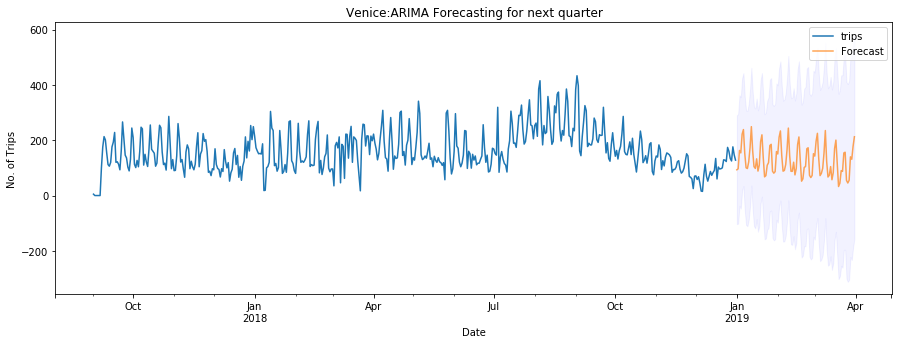

In [21]:
pred1 = results.get_prediction(start='2019-01-01', end='2019-03-31', dynamic=False)
pred1_ci = pred1.conf_int()
ax=Data_Venice_D.plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(15,5))
ax.fill_between(pred1_ci.index,
                pred1_ci.iloc[:, 0],
                pred1_ci.iloc[:, 1], color='b', alpha=0.05)
ax.set_xlabel('Date')
ax.set_ylabel('No. of Trips')
ax.set_title("Venice:ARIMA Forecasting for next quarter")
plt.legend()

In [22]:
y_truth = test_ven #Actual number of trips for validation data
y_forecasted = pred.predicted_mean #Predicted number of trips for validation data
y_future = pred1.predicted_mean #predicted  number of trips for next  quarter

Exporting this data file in Microsoft Excel to further analyze them.

In [23]:
y_truth.to_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/for/ventruth.xlsx')
y_forecasted.to_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/for/venforecast.xlsx')
y_future.to_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/for/venfuture.xlsx')